In [633]:
import pandas as pd
import missingno as msno
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection, preprocessing


%matplotlib inline




In [634]:
train_df=pd.read_csv('Sberbank-Russian-Housing-Market/train.csv',parse_dates=['timestamp']).set_index('id')
test_df=pd.read_csv('Sberbank-Russian-Housing-Market/test.csv',parse_dates=['timestamp']).set_index('id')
train_df['isTrain']=1
test_df['isTrain']=0
combine_df=pd.concat([train_df,test_df])
combine_df.shape
macro_df=pd.read_csv('Sberbank-Russian-Housing-Market/macro.csv',parse_dates=['timestamp'])

In [635]:
print(combine_df.shape)

(38133, 292)


In [636]:
combine_df=pd.merge(combine_df,macro_df,on='timestamp',how='left')
combine_df.head()


,0_13_all,0_13_female,0_13_male,0_17_all,0_17_female,0_17_male,0_6_all,0_6_female,0_6_male,16_29_all,...,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
0,18654,8945,9709,23603,11317,12286,9576,4677,4899,17508,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
1,13729,6800,6929,17700,8702,8998,6880,3414,3466,15164,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
2,11252,5336,5916,14884,7063,7821,5879,2784,3095,19401,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
3,24934,12152,12782,32063,15550,16513,13087,6442,6645,3292,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
4,11631,5408,6223,15237,7124,8113,5706,2724,2982,5164,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0


In [637]:
print combine_df.timestamp.dtype

datetime64[ns]


In [638]:
print(combine_df.shape)
print(macro_df.shape)
print(train_df.shape)
print(test_df.shape)

(38133, 391)
(2484, 100)
(30471, 292)
(7662, 291)


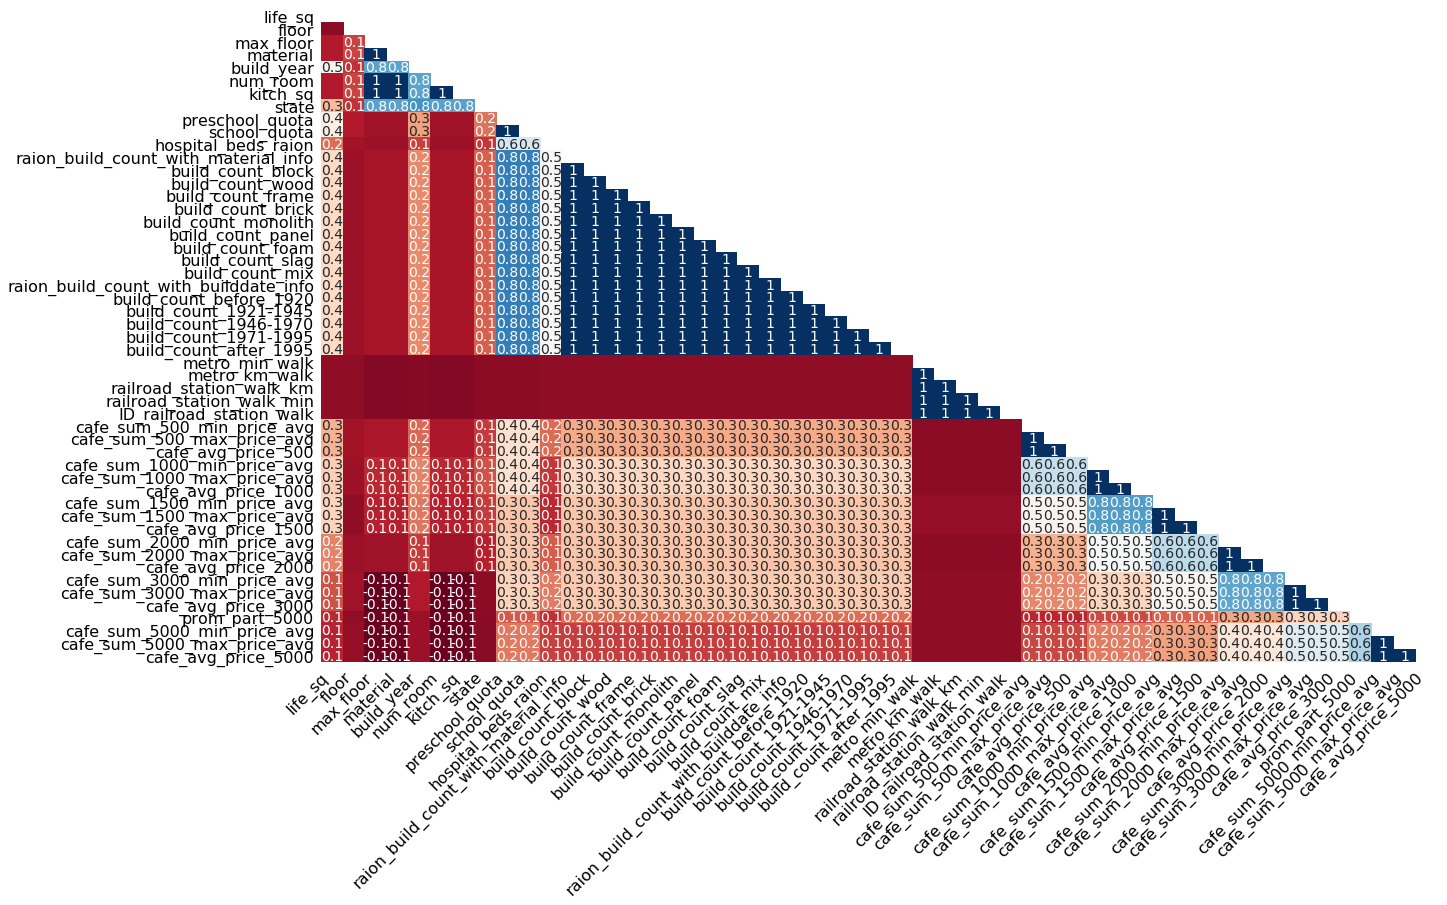

In [639]:
col_missing = train_df.isnull().any()[train_df.isnull().any()].index
#msno.matrix(df=train_df[col_missing], figsize=(20, 14), color=(0.42, 0.1, 0.05))
train_df[col_missing].apply(lambda c:len(c[c.isnull()])).sort_values()
msno.heatmap(df=train_df[col_missing])

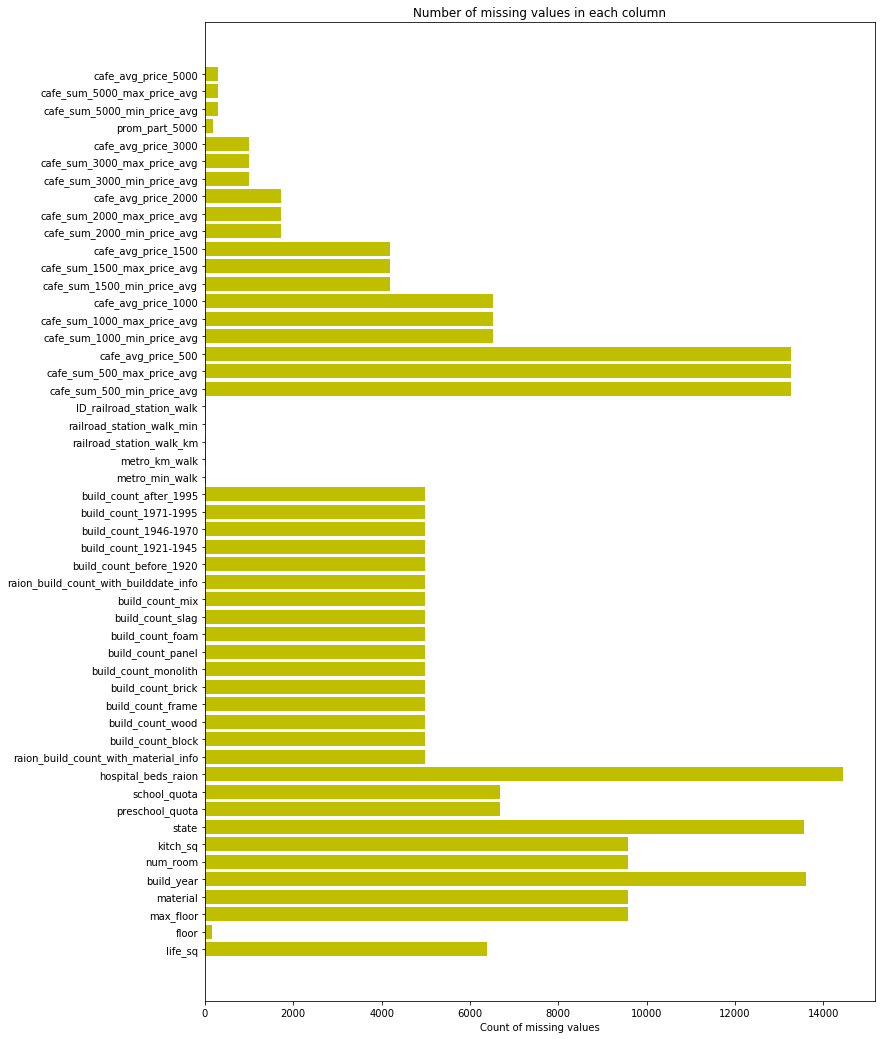

In [640]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns=['column_name','missing_count']
missing_df=missing_df[missing_df['missing_count']>0]
ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='y')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

In [641]:
#dealing with outliers

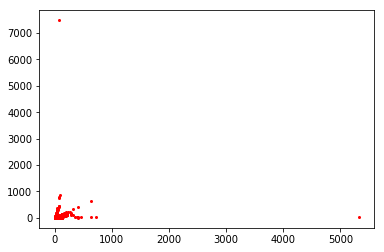

In [642]:
plt.scatter(combine_df.full_sq,combine_df.life_sq,s=4,c='red')

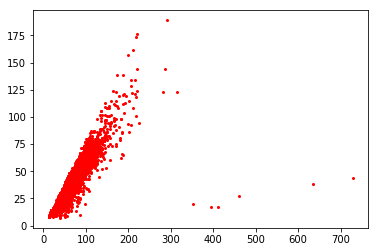

In [643]:
combine_df.loc[combine_df.full_sq>1000,'full_sq']=np.nan
combine_df.loc[combine_df.life_sq>1000,'life_sq']=np.nan
combine_df.loc[combine_df.life_sq>combine_df.full_sq*0.8,'life_sq']=np.nan
combine_df.loc[combine_df.full_sq<3,'full_sq'] = np.nan
combine_df.loc[combine_df.life_sq<3,'life_sq']=np.nan
plt.scatter(combine_df.full_sq,combine_df.life_sq,s=4,c='red')

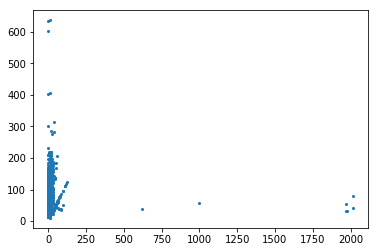

In [644]:
plt.scatter(combine_df.kitch_sq,combine_df.full_sq,s=4)
combine_df.loc[combine_df.kitch_sq>combine_df.life_sq]=np.nan
combine_df.loc[combine_df.kitch_sq>500,'kitch_sq']=np.nan
combine_df.loc[combine_df.kitch_sq<2,'kitch_sq']=np.nan



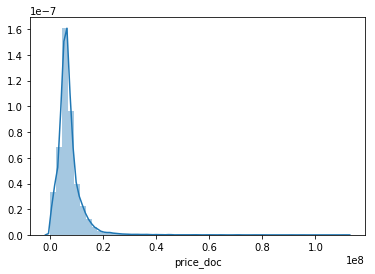

In [645]:

sns.distplot(train_df.loc[train_df['price_doc']>np.log1p(20000000),'price_doc'])




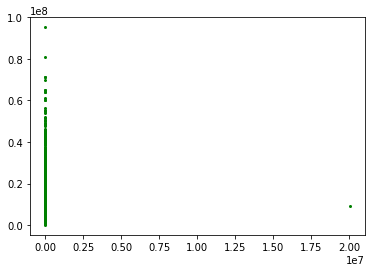

In [646]:
plt.scatter(combine_df.build_year,combine_df.price_doc,s=4,c='green')
combine_df.loc[combine_df.build_year>2018,'build_year']
combine_df.loc[combine_df.build_year==20052009.0,'build_year']=2005
combine_df.loc[combine_df.build_year==4965,'build_year'] = np.nan
combine_df.loc[combine_df.build_year>2021,'build_year'] = np.nan
combine_df.build_year.describe(percentiles= [0.9999,0.10])
combine_df.loc[combine_df.build_year<1950,'build_year']=np.nan






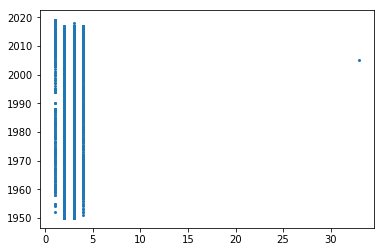

In [647]:
plt.scatter(combine_df.state,combine_df.build_year,s=4)
combine_df.loc[combine_df.state>30,'state']=np.nan




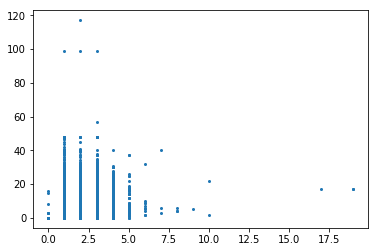

In [648]:
plt.scatter(combine_df.num_room,combine_df.max_floor,s=4)
combine_df.loc[combine_df.num_room>15,'num_room']=np.nan
combine_df.loc[combine_df.num_room==0,'num_room']=np.nan
combine_df.loc[combine_df.max_floor==0]=np.nan


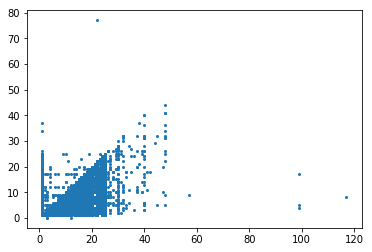

In [649]:
plt.scatter(combine_df.max_floor,combine_df.floor,s=4)
combine_df.loc[combine_df.max_floor<combine_df.floor,'max_floor']=np.nan



In [650]:
month_year = (combine_df.timestamp.dt.month + combine_df.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
month_year_cnt_map
combine_df['month_year_cnt'] = month_year.map(month_year_cnt_map)
week_year=combine_df['timestamp'].dt.weekofyear+combine_df['timestamp'].dt.year*100
week_year_cnt_map=week_year.value_counts().to_dict()
combine_df['week_year_cnt_map']=week_year.map(week_year_cnt_map)
combine_df['month']=combine_df['timestamp'].dt.month
combine_df['dayofweek']=combine_df['timestamp'].dt.dayofweek
combine_df.drop('timestamp',axis=1,inplace=True)


In [651]:
combine_df[['month_year_cnt','dayofweek']]

,month_year_cnt,dayofweek
0,3.0,5.0
1,3.0,1.0
2,3.0,5.0
3,39.0,3.0
4,39.0,0.0
5,39.0,1.0
6,39.0,3.0
7,39.0,4.0
8,39.0,5.0
9,39.0,1.0


In [652]:
combine_df.shape

(38133, 394)

In [653]:
train_df.full_sq.describe()


count    30471.000000
mean        54.214269
std         38.031487
min          0.000000
25%         38.000000
50%         49.000000
75%         63.000000
max       5326.000000
Name: full_sq, dtype: float64

In [655]:
combine_df['area_km']=combine_df['area_m']/1000000
combine_df['desity']=combine_df['raion_popul']/combine_df['area_km']


In [656]:
for c in combine_df.columns:
    if combine_df[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(combine_df[c].values))
        combine_df[c] = lbl.transform(list(combine_df[c].values))
        # x_train.drop(c,axis=1,inplace=True)

In [657]:
print combine_df.shape


(38133, 396)


In [658]:
cor=train_df.corr()
price_corr=cor.price_doc

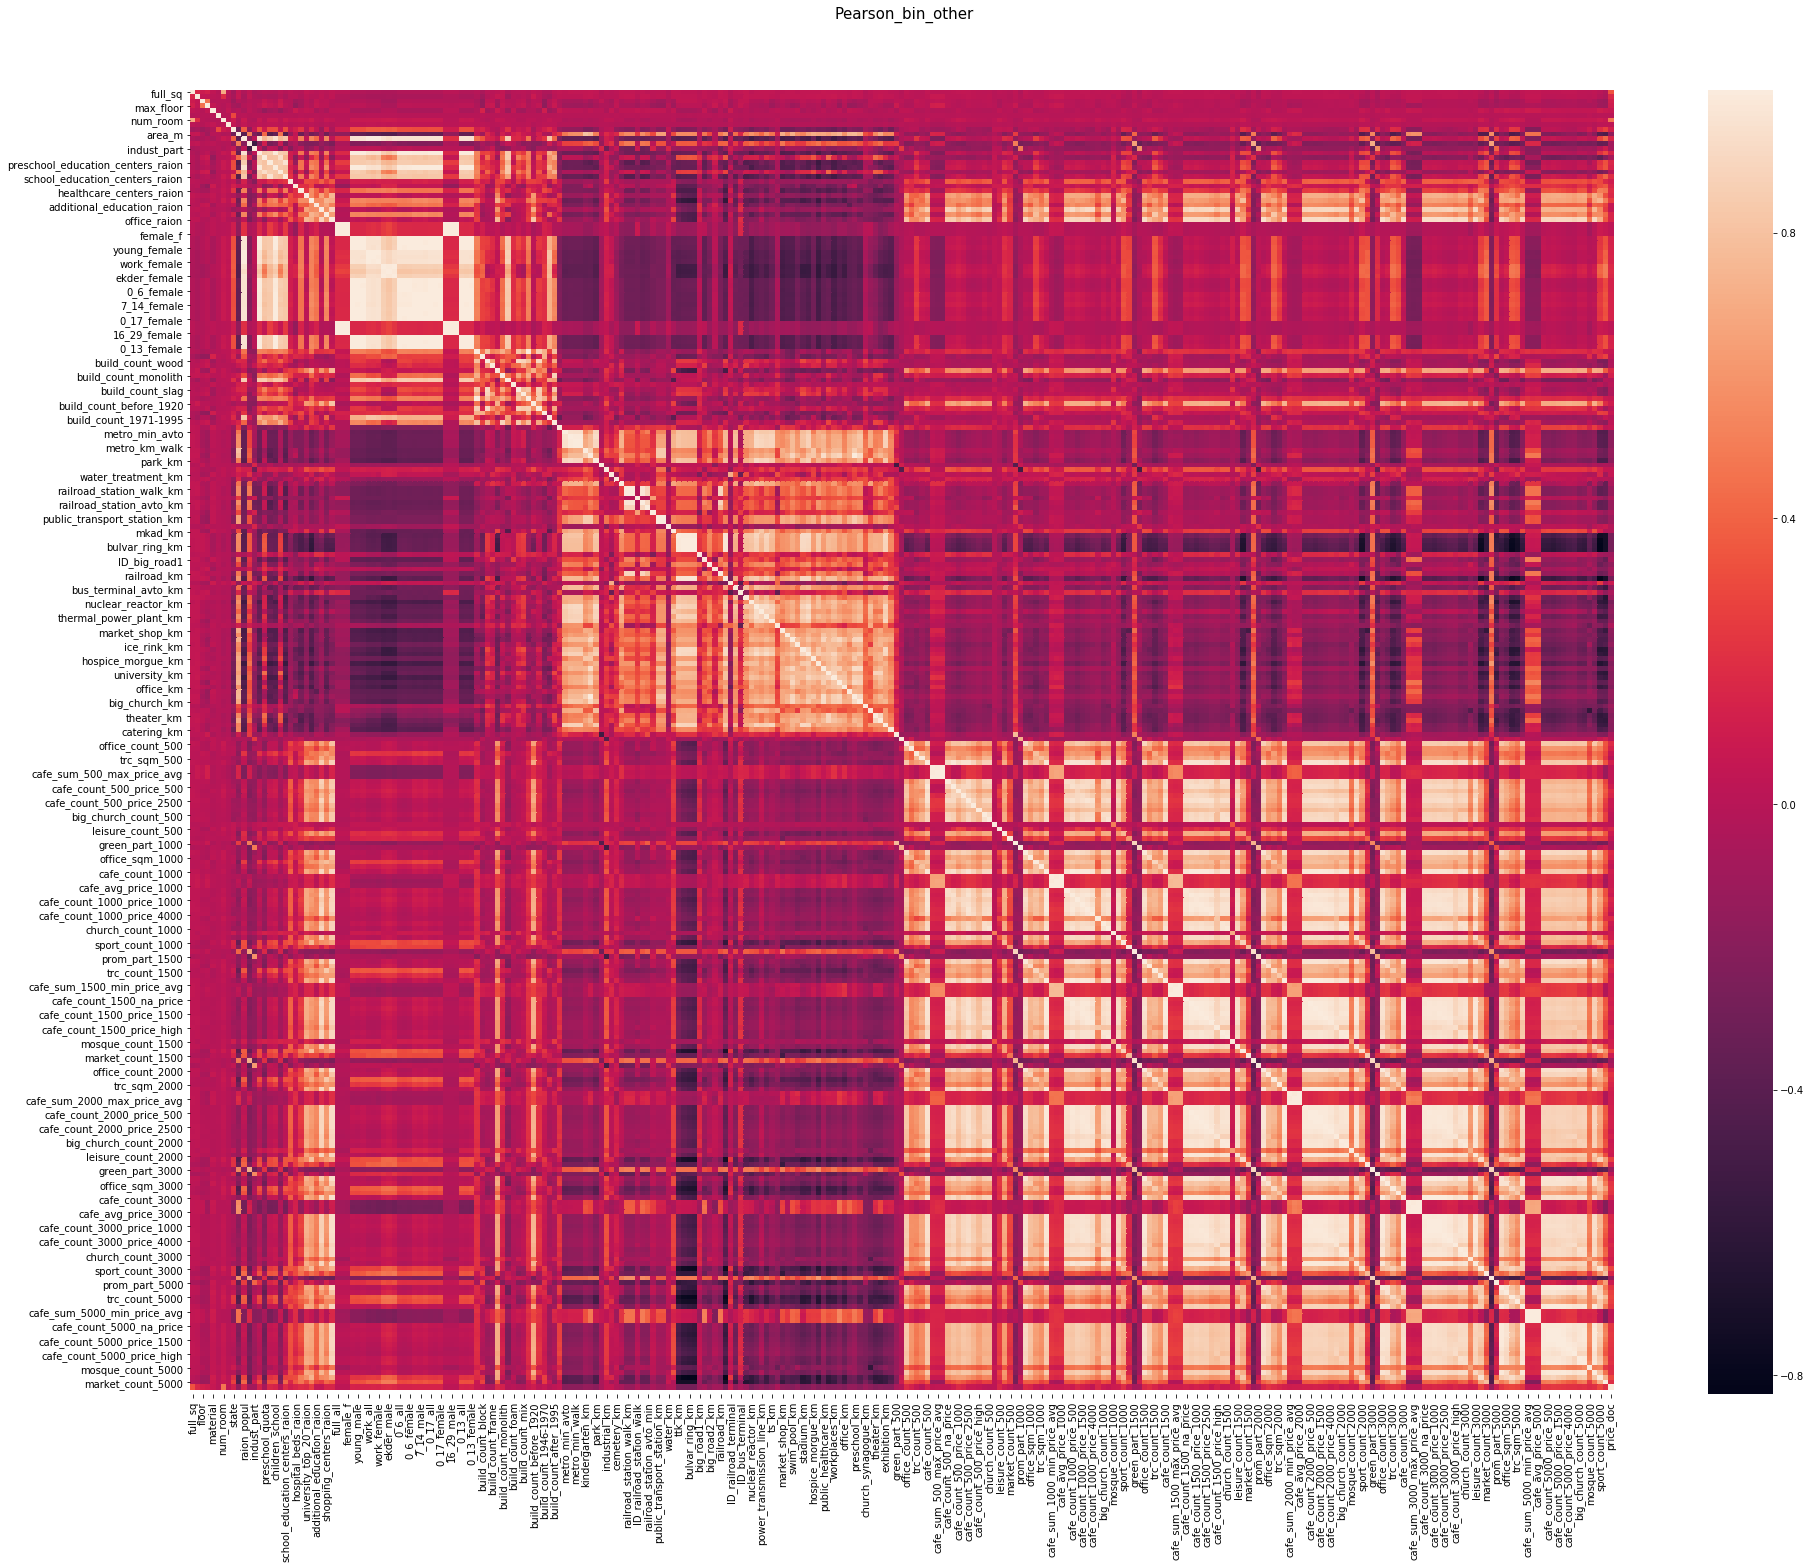

In [659]:
colormap = plt.cm.magma
plt.figure(figsize=(32,24))
plt.title(u'Pearson_bin_other', y=1.05, size=15)
sns.heatmap(train_df.corr())




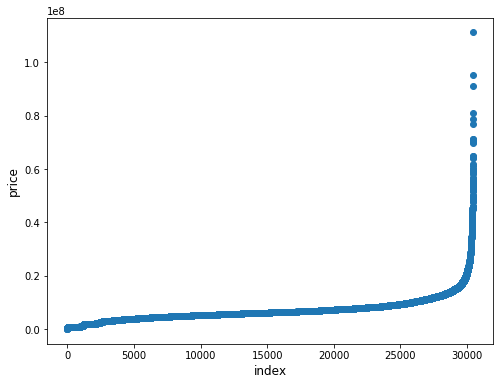

In [660]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.price_doc.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('price', fontsize=12)
plt.show()

In [665]:
combine_df['market_shop']=1/combine_df['market_shop_km']
combine_df['old']=2018-combine_df['build_year']

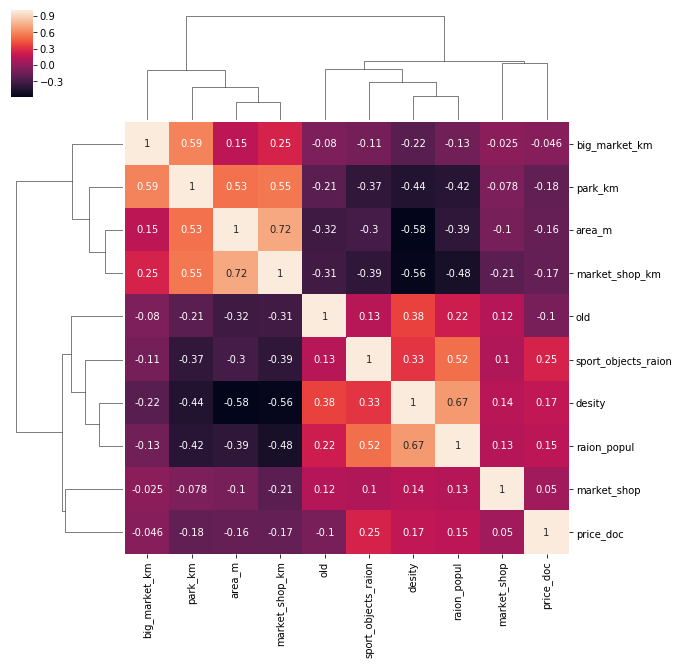

In [667]:
sns.clustermap(combine_df[['area_m' ,'desity','raion_popul','sport_objects_raion','park_km','big_market_km','market_shop_km','market_shop','old',
                  'price_doc']].corr(),annot=True)

plt.show()

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


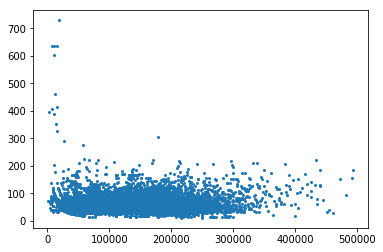

In [668]:
train_df=combine_df.iloc[:30471,:]
test_df=combine_df.iloc[30471:,:]
train_df['mean_price']=train_df['price_doc']/train_df['full_sq']
train_df.loc[train_df.mean_price>500000,'mean_price']=np.nan
plt.scatter(train_df.mean_price,train_df.full_sq,s=4)
outputFile = 'train_featured.csv'
train_df.to_csv(outputFile,index=False)
outputFile = 'test_featured.csv'
test_df.to_csv(outputFile,index=False)